In [9]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (mean_squared_error, accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
import numpy as np
import pandas as pd
import ast
import seaborn as sns

# Preparing the data

In [10]:
data = pd.read_csv('../Cleaning/Cleaned_mini_dataset_for_bootcamp.csv')
data = data.dropna(subset=['max_salary_x']).reset_index(drop=True)
data.dropna(axis=1,how='all', inplace=True)
columns_to_drop = ['industry_id', 'currency_y', 'skill_abr', 'url_x', 'address_x', 'name_x', 'job_posting_url_x', 'location_x', 'skills_desc_x', 'posting_domain_x', 'currency_x', 'zip_code_y_x', 'job_posting_url_y', 'application_url_y', 'application_type_y', 'posting_domain_y', 'skills_desc_y', 'work_type_y', 'inferred_y', 'company_size_y', 'address_y', 'url_y', 'application_url_x', 'description_x_y', 'name_y', 'description_y_y', 'zip_code_y_y', 'Unnamed: 0', 'formatted_experience_level_y', 'country_y', 'location_y', 'state_y', 'company_name_y', 'max_salary_x', 'min_salary_x', 'pay_period_x', 'remote_allowed_x', 'closed_time_x', 'sponsored_x', 'compensation_type_x', 'type_x', 'city_x', 'employee_count_x', 'follower_count_x', 'industry_name_x', 'skill_name_x', 'formatted_work_type_x', 'type_x', 'title_y']
data.drop(columns_to_drop, axis=1, inplace=True)
# Rename columns to be more readable
new_column_names = {
    'company_name_x': 'Company Name',
    'title_x': 'Job Title',
    'description_x_x': 'Job Description',
    'formatted_work_type_x': 'Work Type',
    'application_type_x': 'Application Type',
    'formatted_experience_level_x': 'Experience Level',
    'work_type_x': 'Work Category',
    'inferred_x': 'Inferred Data',
    'description_y_x': 'Company Description',
    'company_size_x': 'Company Size',
    'state_x': 'State',
    'country_x': 'Country',
    'title_y': 'Alt Job Title',
    'max_salary_y': 'Max Salary',
    'pay_period_y': 'Pay Period',
    'min_salary_y': 'Min Salary',
    'formatted_work_type_y': 'Alt Work Type',
    'remote_allowed_y': 'Remote Allowed',
    'closed_time_y': 'Closed Time',
    'sponsored_y': 'Sponsored',
    'compensation_type_y': 'Compensation Type',
    'type_y': 'Benefits',
    'city_y': 'City',
    'employee_count_y': 'Employee Count',
    'follower_count_y': 'Follower Count',
    'skill_name_y': 'Skills',
    'industry_name_y': 'Industries'
}

# Rename columns in the DataFrame
data.rename(columns=new_column_names, inplace=True)

# Dropping internships because of sparsity in this dataset
data = data[~data['Experience Level'].str.contains('Internship', case=False, na=False)]
data = data[~data['Experience Level'].str.contains('Not Specified', case=False, na=False)]
data = data[data['Pay Period'] == 'YEARLY']
data = data[data['Country'] == 'US']

data.drop('Sponsored', axis=1, inplace=True)

Q1 = data['Max Salary'].quantile(0.25)
Q3 = data['Max Salary'].quantile(0.75)
IQR = Q3 - Q1

# Filter based on the IQR range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Max Salary'] >= 10000) & (data['Max Salary'] <= upper_bound)]

# Turning Skills and Industries rows back into lists
data['Skills'] = data['Skills'].apply(lambda x: eval(x) if isinstance(x, str) else [])
data['Industries'] = data['Industries'].apply(lambda x: eval(x) if isinstance(x, str) else [])

## Critique three: Better encoding

### Multi-hot encoding

In the first attempt, my teammate and I exploded the dataframe instead of encoding the list columns when trying to represent them visually. We were recommended to try and multi-hot encode the data because it works well for multi-label features. This allows us to easily compute a matrix correlation without having to re-aggregate and interpret our results. There is also the added benefit of keeping each job confined to a single row, which is important because we will not be skewing the data towards job postings with a lot of skills listed.

<Figure size 1600x1200 with 0 Axes>

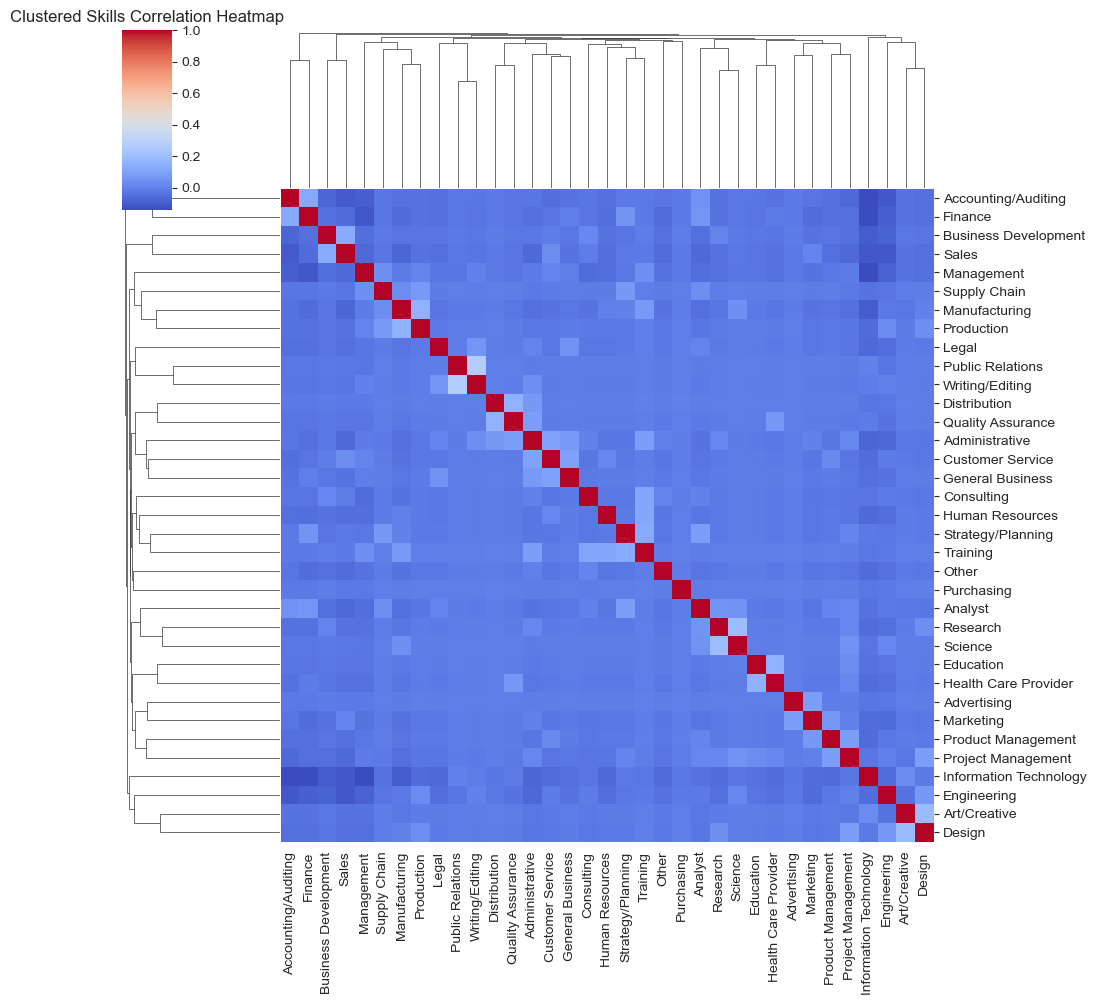

In [11]:
# Convert the 'Skills' column into a multi-hot encoded matrix
skills_encoded = data['Skills'].str.join('|').str.get_dummies()

# Compute the correlation matrix
skills_correlation_matrix = skills_encoded.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.clustermap(skills_correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Clustered Skills Correlation Heatmap')
plt.show()

<Figure size 1600x1200 with 0 Axes>

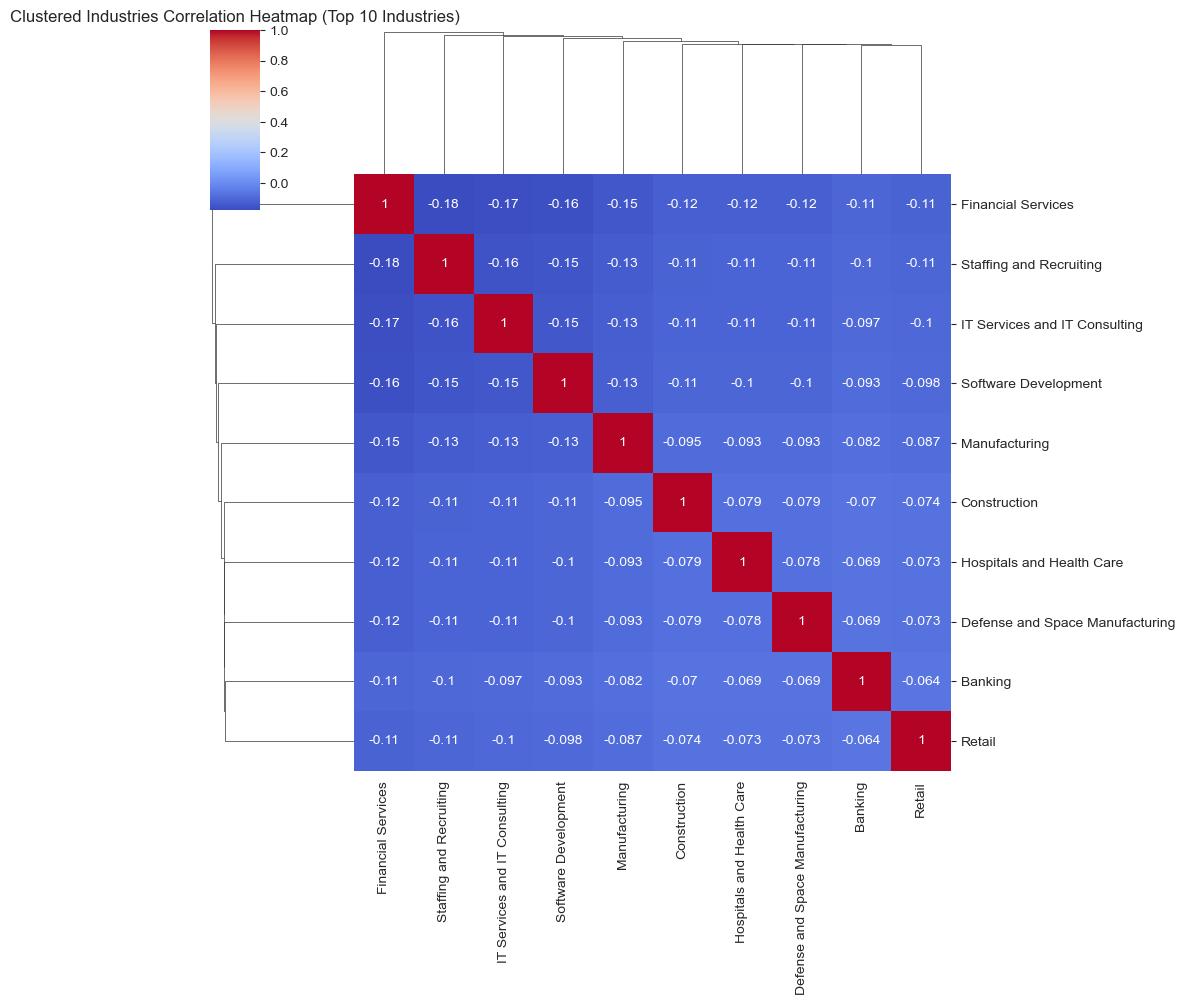

In [12]:
# Identify the top 10 most frequently occurring industries
exploded_industries = data.explode('Industries')
top_10_industries = exploded_industries['Industries'].value_counts().head(10).index

# Filter only rows with industries in the top 10 list
filtered_industries = exploded_industries[exploded_industries['Industries'].isin(top_10_industries)]

industries_encoded = filtered_industries['Industries'].str.get_dummies()
industries_correlation_matrix = industries_encoded.corr(method='pearson')
plt.figure(figsize=(16, 12))
sns.clustermap(industries_correlation_matrix, cmap='coolwarm', annot=True, method='ward')
plt.title('Clustered Industries Correlation Heatmap (Top 10 Industries)')
plt.show()

Not much (linear) relationship between feature presence in both cases. This suggests that not much feature reduction can be done and that we have to include all of these features individually.

### Trying a PCA
The goal was to see whether we could conduct a PCA to reduce the dimensionality of our dataset. The correlation matricies above suggest that there is weak potential for dimensionality reduction through PCA due to lack of collinearity among data.


In [13]:
# Reset index for alignment
skills_encoded = skills_encoded.reset_index(drop=True)
industries_encoded = industries_encoded.reset_index(drop=True)

# Concatenate the two matrices
X = pd.concat([skills_encoded, industries_encoded], axis=1)
X = X.fillna(0) # Just in case

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Scaling the data because PCA is sensitive to outliers
X_scaled = scaler.fit_transform(X)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95) # I want to account for 95% of the variance. Make sure to check for elbows.
X_pca = pca.fit_transform(X_scaled)

Original shape of data: (981, 45)
Reduced shape after PCA: (981, 41)


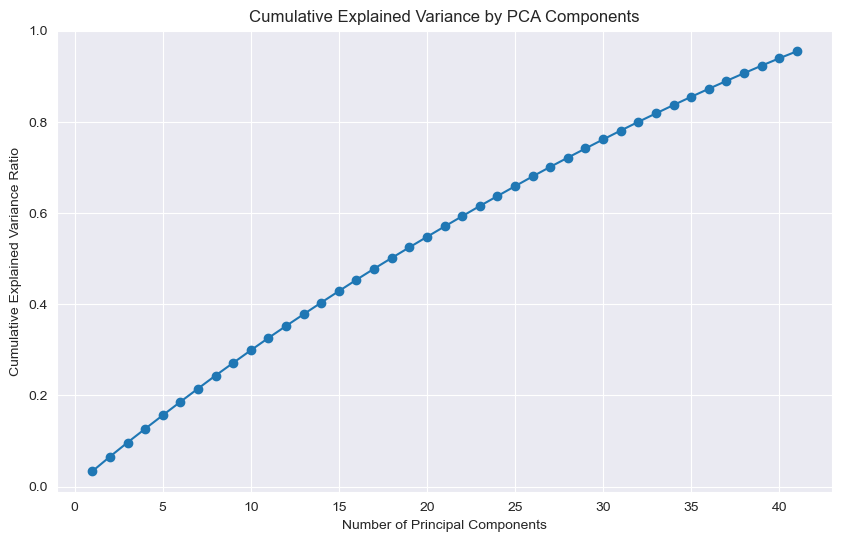

In [15]:
# Print results
print("Original shape of data:", X_scaled.shape)
print("Reduced shape after PCA:", X_pca.shape)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance by PCA Components")
plt.grid(True)
plt.show()

The PCA results indicate that the original 45-dimensional dataset was only reduced to 41 components while retaining 95% of the variance, highlighting minimal redundancy and an inherently high-dimensional structure. The absence of a clear "elbow point" and the near-linear cumulative variance increase suggest that the variance is evenly distributed across features, making PCA ineffective for significant dimensionality reduction. This is likely due to the sparse and distributed nature of the skills and industries data.

# Critique four: Try a different model: RF Classifiers

A random forest classifier was deployed for several reasons:
High dimensionality
High number of categorical features
Non-linear relationships between categories and the target. It is highly unlikely that job features and the likelihood of receiving high paying jobs is linear.
Ease of feature interpretation.
Robustness to missing data.

Minimum salary was removed as a predictor and so was job title. Job title was removed because of the variation in naming conventions as well as the fact that we are not actually predicting acceptance but incomes - so including job title would be cheating almost.

(Two functions and a main call function were built because I designed them to be used in .py files and not notebooks.)


Code can be found under "Big Boy.py". This was run on the mega dataset

---
/opt/anaconda3/envs/my_env/bin/python /Users/adrianeddy/PycharmProjects/EXPO 2024/Data Bootcamp final/Big Boy.py 
Loading dataset...
Handling missing values...
Encoding categorical features...
Scaling numeric features...
Splitting data into train and test sets...
Training Random Forest Classifier...

Accuracy: 81.82%

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      1479
           1       0.69      0.42      0.52       457

    accuracy                           0.82      1936
   macro avg       0.76      0.68      0.70      1936
weighted avg       0.80      0.82      0.80      1936


Top 10 Important Features:
                Feature  Importance
1       Job Description    0.136921
19       Follower Count    0.118936
18       Employee Count    0.114913
20               Skills    0.101771
3      Experience Level    0.083281
21           Industries    0.073344
17                 City    0.068568
0          Company Name    0.067137
6   Company Description    0.064551
8                 State    0.060915

Process finished with exit code 0

---

Accuracy went up to 82%, meaning that 82% of the time we are able to correctly guess someone who earns more than the 3rd percentile.


### Interpretation
Now that we are accounting for more features in the dataset the model is much more accurate in predicting high paying jobs.

However, obvious indicators of salary like experience level have very low feature importance while other more ambiguous predictors like description have high importance. This likely boils down to how the data was being handled. In particular, label encoding highly granular features like description effectively generates a new identifier for every instance to be then interpreted by the model as something significant.

To be frank, I do not understand rf classifiers and encoding techniques enough to break this down much further. But I have a few ideas that I will try and implement:

*Text classification:* Inspired by our class on text classification and rnn techniques, I will try and implement TF-IDF vectorisation to emphasize specific words while downplaying overly common terms so the model can infer higher level insights about certain key words that can effect salary levels without turning each one into a one-off.

*Encoding the lists*: What we did initially with our predictor was binarise the presence of each possible skill or industry effectively **one-hot encoding** each one. This approach was ok, the primary drawback being overfitting and extremely high dimensionality and sparsity. For this reason, I will encode only the top 10 most fequently occurring skills and industries thereby avoiding an imminent explosion of my feature space.

# Text Classification with RF classifier

Again, the code can be found in the file "Big Boy.py" 
Results with big dataset:

---
/opt/anaconda3/envs/my_env/bin/python /Users/adrianeddy/PycharmProjects/EXPO 2024/Data Bootcamp final/Big Boy.py 
Loading dataset...

Accuracy: 83.68%
Precision: 87.70%
Recall: 35.89%
F1 Score: 50.93%

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      1479
           1       0.88      0.36      0.51       457

    accuracy                           0.84      1936
   macro avg       0.85      0.67      0.71      1936
weighted avg       0.84      0.84      0.81      1936


Top 10 Important Features:
            Feature  Importance
848           scale    0.011311
909        strategy    0.009020
27              200    0.008093
358          equity    0.007622
18   Follower Count    0.007562
526      leadership    0.007294
17   Employee Count    0.006749
523            lead    0.006245
907       strategic    0.006158
932           teams    0.005699

---

### Interpretation:
The model's performance indicates strong predictive ability for the majority class (jobs not classified as high-paying), with an accuracy of 84.77% and a perfect precision score of 100% for the high-paying class. However, its recall for the high-paying class is only 34.78%, leading to an F1 score of 51.61%.

The most important features driving the model are just terms. Terms like "practice," "mission," and "leadership" from the job description, alongside company-specific metrics like "Follower Count" and "Employee Count."

# Conclusion and next steps

The results indicate that while the model achieves a high overall accuracy and a flawless precision for the positive class, it struggles to recall those positive cases, capturing only around a third of them. This pattern suggests the presence of class imbalance or thresholding issues. Essentially, the model is playing it safe—opting to primarily predict the majority class to maintain accuracy—at the expense of identifying enough minority class samples.

Possible fixes:
Class rebalancing. If I were to redo this analysis I would undersample the majority class.
Text classigification refinement: Although TF-IFD has improved the model overall, it may introduce noise. To solve this, I found that I could investigate additional domain-relevant features and consider dimensionality reduction here because we are looking at 1000 max features.
Hyperparameter tuning for the random forest through a grid search to find an optimal 'max_depth' for example.

I also was unable to one-hot encode the industries and skills columns due to the already complex nature of the dataframe after all of this preprocessing. So that is something else that will need to be addressed moving forward.

There is also the other issue of feature importance. The top 10 most important features are all individual words from job descriptions which means that we have the same issue as before where the high dimensionality of textual features means that our rf classifier over-exaggerates their collective presence. Deciphering better ways of how to preprocess this is outside of my domain as of this moment so to be candid I am a little stuck with this project right now.
